***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving projectile motion equation
    
    2. Optimize PINN using Stochastic gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

PINN Architecture

In [2]:
n_nodes = 8

class PINNs(nn.Module):
    
    """PINNs"""
    def setup(self):
        # hidden layers
        self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False),
                       nn.tanh,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh]
        # split layers
        self.splitx = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(1, use_bias=False)]
        self.splity = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(1, use_bias=False)]
        
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        t= inputs#[:,0:1]
            
        def get_xy(t):
            for i, lyr in enumerate(self.layers):
                t = lyr(t)
            # split layers
            hidden_x = self.splitx[0](t)
            hidden_x = self.splitx[1](hidden_x)
            hidden_y = self.splity[0](t)
            hidden_y = self.splity[1](hidden_y)
            # output layers
            x = self.splitx[2](hidden_x)
            y = self.splity[2](hidden_y)
            return x, y
                
        x, y = get_xy(t)
            
        # deriviatives needed to obtain are x_t, y_t, x_tt, y_tt
        def get_xy_t(get_xy, t):
            x_t, y_t = jacfwd(get_xy)(t)
            return x_t, y_t
            
        xy_t_vmap = vmap(get_xy_t, in_axes=(None, 0))
        x_t, y_t = xy_t_vmap(get_xy, t)
        x_t = x_t.reshape(-1,1)
        y_t = y_t.reshape(-1,1)
            
        def get_xy_tt(get_xy, t):
            x_tt, y_tt = hessian(get_xy)(t)
            return x_tt, y_tt
            
        xy_tt_vmap = vmap(get_xy_tt, in_axes=(None, 0))
        x_tt, y_tt = xy_tt_vmap(get_xy, t)
        x_tt = x_tt.reshape(-1,1)
        y_tt = y_tt.reshape(-1,1)
            
        action = jnp.hstack([x, y, x_t, y_t, x_tt, y_tt])   
        return action

# initialize model
model = PINNs()    

In [3]:
# choose seed
seed = 1
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,1]) # Dummy input
params = model.init(key2, a) # Initialization call

In [4]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

240

Problem

In [5]:
# function to generate analytical solution
def f_x(t):
    return x0 + t*u0

def f_y(t):
    return y0 + t*v0 - 1./2*g*t**2

def f_t():
    return (vel0*jnp.sin(a0*pi/180) + jnp.sqrt((vel0*jnp.sin(a0*pi/180))**2 + 2*g*y0)) / g

# free fall
def terminal_vel():
    vinf = jnp.sqrt(2*m*g / (d*Cd*A))
    return vinf

def f_yfree(t, vinf):
    y_free = y0 - vinf**2/g*log(jnp.cosh(g*t/vinf))
    return y_free

Hyper parameters and data 

In [6]:
# specify planet to change g, d & a_T
# planet = {'earth': (9.8, 1.2, 2), 'mars': (3.7, 0, 4.5), 'moon': (1.6, 0, 10)}
planet = {'earth': (9.8, 0, 2), 'mars': (3.7, 0, 5.5), 'moon': (1.6, 0, 8)}
g, d, a_T = planet['mars']

# parameter related to flying ball (constant)
m = 0.6
r = 0.12
Cd = 0.54
A = jnp.pi*r**2

# initial condition @(x, y) position
x0, y0 = 0, 2
# initial condition @velocity
vel0 = 10       

# angle of projectile
a0 = 80

# initial velocity
u0 = vel0 * jnp.cos(a0*jnp.pi/180)
v0 = vel0 * jnp.sin(a0*jnp.pi/180)

# time domain: 0 - t_T
t_T = a_T    # let it fly..

t_fitness = 0

# sample size
n = 10000

# PDE data
t = jnp.linspace(0, t_T, n).reshape(-1, 1)
data_pde = t
labels_pde_x = f_x(t)
labels_pde_y = f_y(t)

Loss Function

In [7]:
# loss function parameter
lmbda = 1 #500

In [8]:
def loss(params, inputs):
    t = inputs[:,0:1]
    pred = model.apply(format_params_fn(params), t)
    x, y, x_t, y_t, x_tt, y_tt = pred[:,0:1], pred[:,1:2], pred[:,2:3], pred[:,3:4], pred[:,4:5], pred[:,5:6]
    # ground truth
    x_true = f_x(t)
    y_true = f_y(t)  
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
    # initial conditions (which define the problem)
    ic_1 = jnp.sum(jnp.square((x_true - x)*_ic)) / jnp.sum(_ic)
    ic_2 = jnp.sum(jnp.square((y_true - y)*_ic)) / jnp.sum(_ic)
    ic_3 = jnp.sum(jnp.square((x_t - u0)*_ic)) / jnp.sum(_ic)
    ic_4 = jnp.sum(jnp.square((y_t - v0)*_ic)) / jnp.sum(_ic)
    # sum up all initial conditions
    ic_mse = ic_1 + ic_2 + ic_3 + ic_4
    # consider drag effect
    V = jnp.sqrt( (x_t)**2 + (y_t)**2 )
    C = 0.5*d*Cd*A/m
    R = C*V    
    # PDE (physics laws): v*u_x = k*u_xx  
    pde_x = x_tt + R*x_t
    pde_y = y_tt + R*y_t + g
    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde_x = pde_x *_pde
    pde_y = pde_y *_pde        
    pde_residuals_x = jnp.sum(jnp.square(pde_x)) / jnp.sum(_pde)
    pde_residuals_y = jnp.sum(jnp.square(pde_y)) / jnp.sum(_pde)
    pde_mse = pde_residuals_x + pde_residuals_y    
    pde_mse = pde_mse / lmbda  
    loss = pde_mse + ic_mse
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [9]:
def update(params, opt_state, batch_data):
    loss_value, grad = loss_grad(params, batch_data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [10]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer (SGD)

In [11]:
alpha = 0.001
optimizer = optax.sgd(learning_rate=alpha)
opt_state = optimizer.init(params)

Minibatching

In [12]:
BS = 100

data_ic = data_pde[(0,),:]
def minibatch(train_iters):
    _batch = jax.random.choice(random.PRNGKey(train_iters), n, (BS,))
    batch_data = jnp.vstack([data_pde[_batch], data_ic])
    return batch_data

minibatch = jit(minibatch)

Training 

In [13]:
# store weights
papas = {}
papas[0] = params

max_iters = 1500000
minloss = jnp.inf
fullbatchloss = jnp.inf
fullbatchloss_ls = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    # compute full batch loss (every 1 iterations)
    if (train_iters % 1 == 0):
        loss_value, _ = loss_grad(params, data_pde)    
        fullbatchloss = min(fullbatchloss, loss_value)
    # mini-batching
    batch_data = minibatch(train_iters)
    # stochastic update
    start = time.time()
    params, opt_state, loss_value = update(params, opt_state, batch_data)
    end = time.time()
    # store hsitory.
    runtime += (end-start)   
    fullbatchloss_ls.append([train_iters, runtime, loss_value, fullbatchloss])
    # append weights
    save_iters = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
    if (train_iters in save_iters):
        papas[train_iters] = params
        #print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
    # store weights when the full-batch loss is smallest
    if fullbatchloss < minloss:
        print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
        minloss = fullbatchloss
        papas[-1] = params
    train_iters += 1
              
# final train_iters
print (train_iters, minloss)

iter. = 0  time = 1.30s  loss = 1.18e+02  min. (full batch) loss = 1.18e+02
iter. = 1  time = 1.30s  loss = 1.17e+02  min. (full batch) loss = 1.17e+02
iter. = 2  time = 1.31s  loss = 1.16e+02  min. (full batch) loss = 1.16e+02
iter. = 3  time = 1.31s  loss = 1.15e+02  min. (full batch) loss = 1.15e+02
iter. = 4  time = 1.31s  loss = 1.15e+02  min. (full batch) loss = 1.15e+02
iter. = 5  time = 1.31s  loss = 1.14e+02  min. (full batch) loss = 1.14e+02
iter. = 6  time = 1.31s  loss = 1.13e+02  min. (full batch) loss = 1.13e+02
iter. = 7  time = 1.31s  loss = 1.12e+02  min. (full batch) loss = 1.12e+02
iter. = 8  time = 1.31s  loss = 1.11e+02  min. (full batch) loss = 1.11e+02
iter. = 9  time = 1.31s  loss = 1.10e+02  min. (full batch) loss = 1.10e+02
iter. = 10  time = 1.31s  loss = 1.09e+02  min. (full batch) loss = 1.09e+02
iter. = 11  time = 1.31s  loss = 1.08e+02  min. (full batch) loss = 1.08e+02
iter. = 12  time = 1.31s  loss = 1.07e+02  min. (full batch) loss = 1.07e+02
iter. = 1

iter. = 163  time = 1.35s  loss = 2.06e+01  min. (full batch) loss = 1.82e+01
iter. = 164  time = 1.35s  loss = 1.83e+01  min. (full batch) loss = 1.82e+01
iter. = 165  time = 1.35s  loss = 1.78e+01  min. (full batch) loss = 1.82e+01
iter. = 166  time = 1.35s  loss = 1.59e+01  min. (full batch) loss = 1.81e+01
iter. = 168  time = 1.35s  loss = 1.90e+01  min. (full batch) loss = 1.81e+01
iter. = 169  time = 1.35s  loss = 1.87e+01  min. (full batch) loss = 1.80e+01
iter. = 170  time = 1.35s  loss = 1.83e+01  min. (full batch) loss = 1.80e+01
iter. = 171  time = 1.36s  loss = 1.81e+01  min. (full batch) loss = 1.80e+01
iter. = 172  time = 1.36s  loss = 1.85e+01  min. (full batch) loss = 1.79e+01
iter. = 173  time = 1.36s  loss = 1.81e+01  min. (full batch) loss = 1.79e+01
iter. = 174  time = 1.36s  loss = 1.91e+01  min. (full batch) loss = 1.78e+01
iter. = 176  time = 1.36s  loss = 1.90e+01  min. (full batch) loss = 1.78e+01
iter. = 177  time = 1.36s  loss = 1.93e+01  min. (full batch) lo

iter. = 332  time = 1.41s  loss = 1.35e+01  min. (full batch) loss = 1.40e+01
iter. = 333  time = 1.41s  loss = 1.40e+01  min. (full batch) loss = 1.40e+01
iter. = 334  time = 1.41s  loss = 1.38e+01  min. (full batch) loss = 1.40e+01
iter. = 335  time = 1.41s  loss = 1.35e+01  min. (full batch) loss = 1.40e+01
iter. = 336  time = 1.41s  loss = 1.42e+01  min. (full batch) loss = 1.40e+01
iter. = 337  time = 1.41s  loss = 1.57e+01  min. (full batch) loss = 1.39e+01
iter. = 339  time = 1.41s  loss = 1.32e+01  min. (full batch) loss = 1.39e+01
iter. = 340  time = 1.41s  loss = 1.45e+01  min. (full batch) loss = 1.39e+01
iter. = 343  time = 1.41s  loss = 1.27e+01  min. (full batch) loss = 1.38e+01
iter. = 346  time = 1.41s  loss = 1.39e+01  min. (full batch) loss = 1.38e+01
iter. = 347  time = 1.41s  loss = 1.51e+01  min. (full batch) loss = 1.38e+01
iter. = 349  time = 1.41s  loss = 1.40e+01  min. (full batch) loss = 1.38e+01
iter. = 350  time = 1.41s  loss = 1.34e+01  min. (full batch) lo

iter. = 526  time = 1.47s  loss = 1.15e+01  min. (full batch) loss = 1.14e+01
iter. = 527  time = 1.47s  loss = 1.20e+01  min. (full batch) loss = 1.14e+01
iter. = 529  time = 1.47s  loss = 1.20e+01  min. (full batch) loss = 1.14e+01
iter. = 530  time = 1.47s  loss = 1.16e+01  min. (full batch) loss = 1.14e+01
iter. = 531  time = 1.47s  loss = 1.18e+01  min. (full batch) loss = 1.13e+01
iter. = 532  time = 1.47s  loss = 1.16e+01  min. (full batch) loss = 1.13e+01
iter. = 533  time = 1.47s  loss = 1.15e+01  min. (full batch) loss = 1.13e+01
iter. = 534  time = 1.47s  loss = 1.15e+01  min. (full batch) loss = 1.13e+01
iter. = 535  time = 1.47s  loss = 1.15e+01  min. (full batch) loss = 1.13e+01
iter. = 536  time = 1.47s  loss = 1.15e+01  min. (full batch) loss = 1.13e+01
iter. = 537  time = 1.47s  loss = 1.09e+01  min. (full batch) loss = 1.13e+01
iter. = 539  time = 1.47s  loss = 1.09e+01  min. (full batch) loss = 1.13e+01
iter. = 540  time = 1.47s  loss = 1.17e+01  min. (full batch) lo

iter. = 711  time = 1.52s  loss = 9.63e+00  min. (full batch) loss = 9.72e+00
iter. = 712  time = 1.52s  loss = 1.02e+01  min. (full batch) loss = 9.71e+00
iter. = 713  time = 1.52s  loss = 9.60e+00  min. (full batch) loss = 9.70e+00
iter. = 714  time = 1.52s  loss = 9.46e+00  min. (full batch) loss = 9.70e+00
iter. = 715  time = 1.52s  loss = 9.87e+00  min. (full batch) loss = 9.69e+00
iter. = 717  time = 1.53s  loss = 9.22e+00  min. (full batch) loss = 9.68e+00
iter. = 718  time = 1.53s  loss = 9.92e+00  min. (full batch) loss = 9.67e+00
iter. = 719  time = 1.53s  loss = 1.07e+01  min. (full batch) loss = 9.66e+00
iter. = 720  time = 1.53s  loss = 9.43e+00  min. (full batch) loss = 9.65e+00
iter. = 722  time = 1.53s  loss = 9.68e+00  min. (full batch) loss = 9.64e+00
iter. = 723  time = 1.53s  loss = 9.92e+00  min. (full batch) loss = 9.63e+00
iter. = 724  time = 1.53s  loss = 9.02e+00  min. (full batch) loss = 9.62e+00
iter. = 725  time = 1.53s  loss = 9.67e+00  min. (full batch) lo

iter. = 914  time = 1.58s  loss = 7.30e+00  min. (full batch) loss = 8.54e+00
iter. = 915  time = 1.58s  loss = 8.25e+00  min. (full batch) loss = 8.53e+00
iter. = 916  time = 1.58s  loss = 8.12e+00  min. (full batch) loss = 8.53e+00
iter. = 917  time = 1.58s  loss = 8.89e+00  min. (full batch) loss = 8.53e+00
iter. = 918  time = 1.58s  loss = 9.34e+00  min. (full batch) loss = 8.52e+00
iter. = 920  time = 1.58s  loss = 9.71e+00  min. (full batch) loss = 8.51e+00
iter. = 923  time = 1.58s  loss = 7.76e+00  min. (full batch) loss = 8.50e+00
iter. = 924  time = 1.58s  loss = 7.87e+00  min. (full batch) loss = 8.50e+00
iter. = 925  time = 1.58s  loss = 9.12e+00  min. (full batch) loss = 8.49e+00
iter. = 927  time = 1.58s  loss = 8.14e+00  min. (full batch) loss = 8.49e+00
iter. = 928  time = 1.58s  loss = 8.31e+00  min. (full batch) loss = 8.48e+00
iter. = 929  time = 1.58s  loss = 9.75e+00  min. (full batch) loss = 8.48e+00
iter. = 933  time = 1.59s  loss = 8.26e+00  min. (full batch) lo

iter. = 1099  time = 1.64s  loss = 8.17e+00  min. (full batch) loss = 7.93e+00
iter. = 1100  time = 1.64s  loss = 7.71e+00  min. (full batch) loss = 7.92e+00
iter. = 1101  time = 1.64s  loss = 7.69e+00  min. (full batch) loss = 7.92e+00
iter. = 1102  time = 1.64s  loss = 8.71e+00  min. (full batch) loss = 7.92e+00
iter. = 1103  time = 1.64s  loss = 7.47e+00  min. (full batch) loss = 7.92e+00
iter. = 1105  time = 1.64s  loss = 8.16e+00  min. (full batch) loss = 7.91e+00
iter. = 1106  time = 1.64s  loss = 7.88e+00  min. (full batch) loss = 7.91e+00
iter. = 1108  time = 1.64s  loss = 8.41e+00  min. (full batch) loss = 7.91e+00
iter. = 1109  time = 1.64s  loss = 8.10e+00  min. (full batch) loss = 7.90e+00
iter. = 1110  time = 1.64s  loss = 8.11e+00  min. (full batch) loss = 7.90e+00
iter. = 1112  time = 1.64s  loss = 7.98e+00  min. (full batch) loss = 7.90e+00
iter. = 1113  time = 1.64s  loss = 6.98e+00  min. (full batch) loss = 7.89e+00
iter. = 1114  time = 1.64s  loss = 8.35e+00  min. (f

iter. = 1289  time = 1.69s  loss = 7.48e+00  min. (full batch) loss = 7.47e+00
iter. = 1292  time = 1.70s  loss = 7.78e+00  min. (full batch) loss = 7.47e+00
iter. = 1294  time = 1.70s  loss = 7.35e+00  min. (full batch) loss = 7.46e+00
iter. = 1295  time = 1.70s  loss = 7.95e+00  min. (full batch) loss = 7.46e+00
iter. = 1296  time = 1.70s  loss = 7.66e+00  min. (full batch) loss = 7.46e+00
iter. = 1298  time = 1.70s  loss = 7.39e+00  min. (full batch) loss = 7.46e+00
iter. = 1300  time = 1.70s  loss = 8.44e+00  min. (full batch) loss = 7.45e+00
iter. = 1302  time = 1.70s  loss = 8.27e+00  min. (full batch) loss = 7.45e+00
iter. = 1303  time = 1.70s  loss = 6.83e+00  min. (full batch) loss = 7.44e+00
iter. = 1304  time = 1.70s  loss = 6.61e+00  min. (full batch) loss = 7.44e+00
iter. = 1305  time = 1.70s  loss = 7.58e+00  min. (full batch) loss = 7.44e+00
iter. = 1307  time = 1.70s  loss = 8.07e+00  min. (full batch) loss = 7.43e+00
iter. = 1309  time = 1.70s  loss = 7.35e+00  min. (f

iter. = 1486  time = 1.75s  loss = 7.12e+00  min. (full batch) loss = 7.10e+00
iter. = 1487  time = 1.75s  loss = 6.71e+00  min. (full batch) loss = 7.09e+00
iter. = 1488  time = 1.75s  loss = 7.83e+00  min. (full batch) loss = 7.09e+00
iter. = 1489  time = 1.75s  loss = 6.94e+00  min. (full batch) loss = 7.09e+00
iter. = 1490  time = 1.75s  loss = 7.28e+00  min. (full batch) loss = 7.09e+00
iter. = 1492  time = 1.75s  loss = 7.63e+00  min. (full batch) loss = 7.09e+00
iter. = 1494  time = 1.75s  loss = 6.47e+00  min. (full batch) loss = 7.08e+00
iter. = 1495  time = 1.75s  loss = 6.21e+00  min. (full batch) loss = 7.08e+00
iter. = 1496  time = 1.75s  loss = 6.23e+00  min. (full batch) loss = 7.08e+00
iter. = 1497  time = 1.75s  loss = 6.11e+00  min. (full batch) loss = 7.08e+00
iter. = 1498  time = 1.75s  loss = 6.75e+00  min. (full batch) loss = 7.08e+00
iter. = 1499  time = 1.75s  loss = 7.38e+00  min. (full batch) loss = 7.07e+00
iter. = 1500  time = 1.76s  loss = 7.11e+00  min. (f

iter. = 1674  time = 1.81s  loss = 6.88e+00  min. (full batch) loss = 6.80e+00
iter. = 1675  time = 1.81s  loss = 7.09e+00  min. (full batch) loss = 6.80e+00
iter. = 1676  time = 1.81s  loss = 6.56e+00  min. (full batch) loss = 6.80e+00
iter. = 1677  time = 1.81s  loss = 7.14e+00  min. (full batch) loss = 6.79e+00
iter. = 1678  time = 1.81s  loss = 6.92e+00  min. (full batch) loss = 6.79e+00
iter. = 1680  time = 1.81s  loss = 6.74e+00  min. (full batch) loss = 6.79e+00
iter. = 1681  time = 1.81s  loss = 7.42e+00  min. (full batch) loss = 6.79e+00
iter. = 1682  time = 1.81s  loss = 6.82e+00  min. (full batch) loss = 6.79e+00
iter. = 1683  time = 1.81s  loss = 7.03e+00  min. (full batch) loss = 6.79e+00
iter. = 1685  time = 1.81s  loss = 6.48e+00  min. (full batch) loss = 6.78e+00
iter. = 1687  time = 1.81s  loss = 6.05e+00  min. (full batch) loss = 6.78e+00
iter. = 1689  time = 1.81s  loss = 5.62e+00  min. (full batch) loss = 6.78e+00
iter. = 1690  time = 1.81s  loss = 6.99e+00  min. (f

iter. = 1869  time = 1.86s  loss = 6.17e+00  min. (full batch) loss = 6.55e+00
iter. = 1870  time = 1.86s  loss = 6.80e+00  min. (full batch) loss = 6.55e+00
iter. = 1875  time = 1.86s  loss = 5.88e+00  min. (full batch) loss = 6.53e+00
iter. = 1876  time = 1.86s  loss = 7.40e+00  min. (full batch) loss = 6.53e+00
iter. = 1877  time = 1.87s  loss = 6.22e+00  min. (full batch) loss = 6.53e+00
iter. = 1878  time = 1.87s  loss = 6.86e+00  min. (full batch) loss = 6.53e+00
iter. = 1879  time = 1.87s  loss = 6.16e+00  min. (full batch) loss = 6.53e+00
iter. = 1880  time = 1.87s  loss = 6.47e+00  min. (full batch) loss = 6.53e+00
iter. = 1881  time = 1.87s  loss = 6.40e+00  min. (full batch) loss = 6.53e+00
iter. = 1882  time = 1.87s  loss = 7.11e+00  min. (full batch) loss = 6.53e+00
iter. = 1884  time = 1.87s  loss = 6.92e+00  min. (full batch) loss = 6.52e+00
iter. = 1885  time = 1.87s  loss = 6.38e+00  min. (full batch) loss = 6.52e+00
iter. = 1886  time = 1.87s  loss = 5.97e+00  min. (f

iter. = 2300  time = 1.98s  loss = 6.58e+00  min. (full batch) loss = 6.18e+00
iter. = 2301  time = 1.98s  loss = 6.33e+00  min. (full batch) loss = 6.16e+00
iter. = 2302  time = 1.98s  loss = 6.22e+00  min. (full batch) loss = 6.12e+00
iter. = 2303  time = 1.98s  loss = 6.08e+00  min. (full batch) loss = 6.10e+00
iter. = 2304  time = 1.98s  loss = 6.35e+00  min. (full batch) loss = 6.10e+00
iter. = 2306  time = 1.99s  loss = 6.79e+00  min. (full batch) loss = 6.10e+00
iter. = 2307  time = 1.99s  loss = 6.55e+00  min. (full batch) loss = 6.09e+00
iter. = 2330  time = 1.99s  loss = 5.56e+00  min. (full batch) loss = 6.07e+00
iter. = 2331  time = 1.99s  loss = 6.27e+00  min. (full batch) loss = 6.07e+00
iter. = 2332  time = 1.99s  loss = 5.47e+00  min. (full batch) loss = 6.07e+00
iter. = 2333  time = 1.99s  loss = 6.32e+00  min. (full batch) loss = 6.07e+00
iter. = 2338  time = 2.00s  loss = 6.22e+00  min. (full batch) loss = 6.07e+00
iter. = 2339  time = 2.00s  loss = 6.11e+00  min. (f

iter. = 3033  time = 2.20s  loss = 5.11e+00  min. (full batch) loss = 5.61e+00
iter. = 3034  time = 2.20s  loss = 5.93e+00  min. (full batch) loss = 5.60e+00
iter. = 3035  time = 2.20s  loss = 5.78e+00  min. (full batch) loss = 5.60e+00
iter. = 3052  time = 2.20s  loss = 4.93e+00  min. (full batch) loss = 5.59e+00
iter. = 3058  time = 2.20s  loss = 5.46e+00  min. (full batch) loss = 5.58e+00
iter. = 3059  time = 2.20s  loss = 6.65e+00  min. (full batch) loss = 5.58e+00
iter. = 3061  time = 2.20s  loss = 5.53e+00  min. (full batch) loss = 5.58e+00
iter. = 3062  time = 2.20s  loss = 5.19e+00  min. (full batch) loss = 5.58e+00
iter. = 3067  time = 2.21s  loss = 5.88e+00  min. (full batch) loss = 5.58e+00
iter. = 3071  time = 2.21s  loss = 5.07e+00  min. (full batch) loss = 5.58e+00
iter. = 3078  time = 2.21s  loss = 4.29e+00  min. (full batch) loss = 5.57e+00
iter. = 3079  time = 2.21s  loss = 4.89e+00  min. (full batch) loss = 5.57e+00
iter. = 3082  time = 2.21s  loss = 6.58e+00  min. (f

iter. = 3850  time = 2.44s  loss = 4.97e+00  min. (full batch) loss = 5.22e+00
iter. = 3853  time = 2.44s  loss = 5.51e+00  min. (full batch) loss = 5.22e+00
iter. = 3854  time = 2.44s  loss = 5.74e+00  min. (full batch) loss = 5.22e+00
iter. = 3856  time = 2.44s  loss = 5.84e+00  min. (full batch) loss = 5.22e+00
iter. = 3858  time = 2.44s  loss = 5.53e+00  min. (full batch) loss = 5.22e+00
iter. = 3871  time = 2.45s  loss = 5.44e+00  min. (full batch) loss = 5.21e+00
iter. = 3872  time = 2.45s  loss = 5.69e+00  min. (full batch) loss = 5.21e+00
iter. = 3873  time = 2.45s  loss = 6.19e+00  min. (full batch) loss = 5.21e+00
iter. = 3886  time = 2.45s  loss = 5.10e+00  min. (full batch) loss = 5.21e+00
iter. = 3887  time = 2.45s  loss = 5.09e+00  min. (full batch) loss = 5.20e+00
iter. = 3891  time = 2.45s  loss = 5.22e+00  min. (full batch) loss = 5.20e+00
iter. = 3892  time = 2.45s  loss = 4.84e+00  min. (full batch) loss = 5.20e+00
iter. = 3893  time = 2.45s  loss = 5.62e+00  min. (f

iter. = 4703  time = 2.69s  loss = 5.63e+00  min. (full batch) loss = 4.96e+00
iter. = 4707  time = 2.70s  loss = 5.90e+00  min. (full batch) loss = 4.96e+00
iter. = 4709  time = 2.70s  loss = 5.13e+00  min. (full batch) loss = 4.95e+00
iter. = 4719  time = 2.70s  loss = 5.27e+00  min. (full batch) loss = 4.95e+00
iter. = 4721  time = 2.70s  loss = 5.30e+00  min. (full batch) loss = 4.95e+00
iter. = 4726  time = 2.70s  loss = 4.78e+00  min. (full batch) loss = 4.94e+00
iter. = 4728  time = 2.70s  loss = 4.52e+00  min. (full batch) loss = 4.94e+00
iter. = 4729  time = 2.70s  loss = 4.61e+00  min. (full batch) loss = 4.94e+00
iter. = 4737  time = 2.71s  loss = 4.94e+00  min. (full batch) loss = 4.94e+00
iter. = 4738  time = 2.71s  loss = 5.35e+00  min. (full batch) loss = 4.94e+00
iter. = 4739  time = 2.71s  loss = 4.81e+00  min. (full batch) loss = 4.94e+00
iter. = 4741  time = 2.71s  loss = 5.59e+00  min. (full batch) loss = 4.94e+00
iter. = 4744  time = 2.71s  loss = 5.24e+00  min. (f

iter. = 5812  time = 3.02s  loss = 4.92e+00  min. (full batch) loss = 4.70e+00
iter. = 5842  time = 3.03s  loss = 4.65e+00  min. (full batch) loss = 4.69e+00
iter. = 5844  time = 3.03s  loss = 5.17e+00  min. (full batch) loss = 4.69e+00
iter. = 5855  time = 3.03s  loss = 4.21e+00  min. (full batch) loss = 4.69e+00
iter. = 5862  time = 3.04s  loss = 4.53e+00  min. (full batch) loss = 4.69e+00
iter. = 5868  time = 3.04s  loss = 5.10e+00  min. (full batch) loss = 4.69e+00
iter. = 5895  time = 3.05s  loss = 3.75e+00  min. (full batch) loss = 4.69e+00
iter. = 5899  time = 3.05s  loss = 4.24e+00  min. (full batch) loss = 4.68e+00
iter. = 5954  time = 3.06s  loss = 5.01e+00  min. (full batch) loss = 4.67e+00
iter. = 5955  time = 3.06s  loss = 4.56e+00  min. (full batch) loss = 4.67e+00
iter. = 5957  time = 3.06s  loss = 4.52e+00  min. (full batch) loss = 4.67e+00
iter. = 5958  time = 3.06s  loss = 4.88e+00  min. (full batch) loss = 4.67e+00
iter. = 5960  time = 3.06s  loss = 4.65e+00  min. (f

iter. = 7267  time = 3.44s  loss = 4.71e+00  min. (full batch) loss = 4.48e+00
iter. = 7268  time = 3.44s  loss = 4.50e+00  min. (full batch) loss = 4.48e+00
iter. = 7270  time = 3.44s  loss = 5.01e+00  min. (full batch) loss = 4.47e+00
iter. = 7275  time = 3.44s  loss = 4.43e+00  min. (full batch) loss = 4.47e+00
iter. = 7276  time = 3.44s  loss = 5.24e+00  min. (full batch) loss = 4.47e+00
iter. = 7290  time = 3.45s  loss = 4.76e+00  min. (full batch) loss = 4.47e+00
iter. = 7346  time = 3.46s  loss = 4.79e+00  min. (full batch) loss = 4.47e+00
iter. = 7347  time = 3.46s  loss = 4.73e+00  min. (full batch) loss = 4.46e+00
iter. = 7372  time = 3.47s  loss = 4.38e+00  min. (full batch) loss = 4.46e+00
iter. = 7373  time = 3.47s  loss = 4.71e+00  min. (full batch) loss = 4.46e+00
iter. = 7378  time = 3.47s  loss = 4.52e+00  min. (full batch) loss = 4.46e+00
iter. = 7380  time = 3.47s  loss = 4.92e+00  min. (full batch) loss = 4.46e+00
iter. = 7418  time = 3.48s  loss = 4.78e+00  min. (f

iter. = 8825  time = 3.89s  loss = 3.91e+00  min. (full batch) loss = 4.31e+00
iter. = 8864  time = 3.90s  loss = 4.94e+00  min. (full batch) loss = 4.31e+00
iter. = 8877  time = 3.91s  loss = 4.17e+00  min. (full batch) loss = 4.31e+00
iter. = 8894  time = 3.91s  loss = 4.10e+00  min. (full batch) loss = 4.31e+00
iter. = 8895  time = 3.91s  loss = 4.45e+00  min. (full batch) loss = 4.31e+00
iter. = 8905  time = 3.91s  loss = 4.48e+00  min. (full batch) loss = 4.31e+00
iter. = 8908  time = 3.92s  loss = 4.24e+00  min. (full batch) loss = 4.31e+00
iter. = 8917  time = 3.92s  loss = 3.84e+00  min. (full batch) loss = 4.31e+00
iter. = 8927  time = 3.92s  loss = 4.74e+00  min. (full batch) loss = 4.31e+00
iter. = 8946  time = 3.93s  loss = 4.15e+00  min. (full batch) loss = 4.30e+00
iter. = 8956  time = 3.93s  loss = 4.57e+00  min. (full batch) loss = 4.30e+00
iter. = 8973  time = 3.93s  loss = 4.48e+00  min. (full batch) loss = 4.30e+00
iter. = 8990  time = 3.94s  loss = 4.50e+00  min. (f

iter. = 10524  time = 4.38s  loss = 4.32e+00  min. (full batch) loss = 4.20e+00
iter. = 10568  time = 4.40s  loss = 3.87e+00  min. (full batch) loss = 4.20e+00
iter. = 10572  time = 4.40s  loss = 3.99e+00  min. (full batch) loss = 4.19e+00
iter. = 10576  time = 4.40s  loss = 3.90e+00  min. (full batch) loss = 4.19e+00
iter. = 10611  time = 4.41s  loss = 4.25e+00  min. (full batch) loss = 4.19e+00
iter. = 10618  time = 4.41s  loss = 3.76e+00  min. (full batch) loss = 4.19e+00
iter. = 10622  time = 4.41s  loss = 4.55e+00  min. (full batch) loss = 4.19e+00
iter. = 10663  time = 4.43s  loss = 3.80e+00  min. (full batch) loss = 4.19e+00
iter. = 10687  time = 4.44s  loss = 4.02e+00  min. (full batch) loss = 4.19e+00
iter. = 10692  time = 4.44s  loss = 3.76e+00  min. (full batch) loss = 4.19e+00
iter. = 10707  time = 4.44s  loss = 3.98e+00  min. (full batch) loss = 4.19e+00
iter. = 10725  time = 4.45s  loss = 4.06e+00  min. (full batch) loss = 4.19e+00
iter. = 10727  time = 4.45s  loss = 3.91

iter. = 12720  time = 5.02s  loss = 4.05e+00  min. (full batch) loss = 4.10e+00
iter. = 12762  time = 5.03s  loss = 4.17e+00  min. (full batch) loss = 4.10e+00
iter. = 12763  time = 5.03s  loss = 4.30e+00  min. (full batch) loss = 4.10e+00
iter. = 12768  time = 5.03s  loss = 3.99e+00  min. (full batch) loss = 4.10e+00
iter. = 12781  time = 5.04s  loss = 4.19e+00  min. (full batch) loss = 4.10e+00
iter. = 12825  time = 5.05s  loss = 4.04e+00  min. (full batch) loss = 4.10e+00
iter. = 12901  time = 5.07s  loss = 4.24e+00  min. (full batch) loss = 4.10e+00
iter. = 12907  time = 5.07s  loss = 4.28e+00  min. (full batch) loss = 4.10e+00
iter. = 12921  time = 5.07s  loss = 4.00e+00  min. (full batch) loss = 4.10e+00
iter. = 12926  time = 5.08s  loss = 3.97e+00  min. (full batch) loss = 4.10e+00
iter. = 12941  time = 5.08s  loss = 3.62e+00  min. (full batch) loss = 4.10e+00
iter. = 12977  time = 5.09s  loss = 3.93e+00  min. (full batch) loss = 4.10e+00
iter. = 12993  time = 5.09s  loss = 3.84

iter. = 15576  time = 5.90s  loss = 4.31e+00  min. (full batch) loss = 4.03e+00
iter. = 15583  time = 5.90s  loss = 3.88e+00  min. (full batch) loss = 4.03e+00
iter. = 15584  time = 5.90s  loss = 4.38e+00  min. (full batch) loss = 4.03e+00
iter. = 15602  time = 5.90s  loss = 4.04e+00  min. (full batch) loss = 4.03e+00
iter. = 15603  time = 5.90s  loss = 3.68e+00  min. (full batch) loss = 4.03e+00
iter. = 15673  time = 5.92s  loss = 4.58e+00  min. (full batch) loss = 4.03e+00
iter. = 15695  time = 5.93s  loss = 3.88e+00  min. (full batch) loss = 4.03e+00
iter. = 15703  time = 5.93s  loss = 4.24e+00  min. (full batch) loss = 4.03e+00
iter. = 15743  time = 5.95s  loss = 4.04e+00  min. (full batch) loss = 4.02e+00
iter. = 15755  time = 5.95s  loss = 3.66e+00  min. (full batch) loss = 4.02e+00
iter. = 15756  time = 5.95s  loss = 3.88e+00  min. (full batch) loss = 4.02e+00
iter. = 15788  time = 5.96s  loss = 3.94e+00  min. (full batch) loss = 4.02e+00
iter. = 15815  time = 5.97s  loss = 3.77

iter. = 19249  time = 6.96s  loss = 3.71e+00  min. (full batch) loss = 3.97e+00
iter. = 19252  time = 6.96s  loss = 3.90e+00  min. (full batch) loss = 3.97e+00
iter. = 19361  time = 6.99s  loss = 3.91e+00  min. (full batch) loss = 3.97e+00
iter. = 19422  time = 7.00s  loss = 3.71e+00  min. (full batch) loss = 3.97e+00
iter. = 19423  time = 7.01s  loss = 3.81e+00  min. (full batch) loss = 3.96e+00
iter. = 19461  time = 7.02s  loss = 4.03e+00  min. (full batch) loss = 3.96e+00
iter. = 19479  time = 7.03s  loss = 4.21e+00  min. (full batch) loss = 3.96e+00
iter. = 19484  time = 7.03s  loss = 4.22e+00  min. (full batch) loss = 3.96e+00
iter. = 19512  time = 7.04s  loss = 3.83e+00  min. (full batch) loss = 3.96e+00
iter. = 19584  time = 7.06s  loss = 3.80e+00  min. (full batch) loss = 3.96e+00
iter. = 19595  time = 7.06s  loss = 3.63e+00  min. (full batch) loss = 3.96e+00
iter. = 19600  time = 7.06s  loss = 4.12e+00  min. (full batch) loss = 3.96e+00
iter. = 19663  time = 7.08s  loss = 4.28

iter. = 24708  time = 8.57s  loss = 3.81e+00  min. (full batch) loss = 3.91e+00
iter. = 24790  time = 8.59s  loss = 3.99e+00  min. (full batch) loss = 3.91e+00
iter. = 24797  time = 8.59s  loss = 4.11e+00  min. (full batch) loss = 3.91e+00
iter. = 24881  time = 8.62s  loss = 3.81e+00  min. (full batch) loss = 3.91e+00
iter. = 25107  time = 8.69s  loss = 3.68e+00  min. (full batch) loss = 3.91e+00
iter. = 25131  time = 8.70s  loss = 3.77e+00  min. (full batch) loss = 3.91e+00
iter. = 25178  time = 8.71s  loss = 3.98e+00  min. (full batch) loss = 3.90e+00
iter. = 25194  time = 8.72s  loss = 3.98e+00  min. (full batch) loss = 3.90e+00
iter. = 25203  time = 8.72s  loss = 3.79e+00  min. (full batch) loss = 3.90e+00
iter. = 25310  time = 8.75s  loss = 3.86e+00  min. (full batch) loss = 3.90e+00
iter. = 25330  time = 8.75s  loss = 3.53e+00  min. (full batch) loss = 3.90e+00
iter. = 25530  time = 8.81s  loss = 3.74e+00  min. (full batch) loss = 3.90e+00
iter. = 25563  time = 8.82s  loss = 3.84

iter. = 33260  time = 11.08s  loss = 3.83e+00  min. (full batch) loss = 3.85e+00
iter. = 33429  time = 11.13s  loss = 3.94e+00  min. (full batch) loss = 3.85e+00
iter. = 33445  time = 11.13s  loss = 4.04e+00  min. (full batch) loss = 3.85e+00
iter. = 33570  time = 11.17s  loss = 3.75e+00  min. (full batch) loss = 3.85e+00
iter. = 33664  time = 11.19s  loss = 4.03e+00  min. (full batch) loss = 3.85e+00
iter. = 33706  time = 11.21s  loss = 3.92e+00  min. (full batch) loss = 3.85e+00
iter. = 33748  time = 11.22s  loss = 3.75e+00  min. (full batch) loss = 3.85e+00
iter. = 33787  time = 11.24s  loss = 3.73e+00  min. (full batch) loss = 3.85e+00
iter. = 34144  time = 11.34s  loss = 3.63e+00  min. (full batch) loss = 3.85e+00
iter. = 34149  time = 11.35s  loss = 3.82e+00  min. (full batch) loss = 3.85e+00
iter. = 34223  time = 11.37s  loss = 4.00e+00  min. (full batch) loss = 3.85e+00
iter. = 34265  time = 11.38s  loss = 3.94e+00  min. (full batch) loss = 3.85e+00
iter. = 34322  time = 11.40s

iter. = 39159  time = 12.85s  loss = 3.59e+00  min. (full batch) loss = 3.74e+00
iter. = 39173  time = 12.85s  loss = 3.46e+00  min. (full batch) loss = 3.74e+00
iter. = 39175  time = 12.85s  loss = 3.66e+00  min. (full batch) loss = 3.74e+00
iter. = 39186  time = 12.86s  loss = 3.50e+00  min. (full batch) loss = 3.74e+00
iter. = 39209  time = 12.86s  loss = 3.52e+00  min. (full batch) loss = 3.74e+00
iter. = 39210  time = 12.86s  loss = 3.88e+00  min. (full batch) loss = 3.74e+00
iter. = 39223  time = 12.87s  loss = 3.64e+00  min. (full batch) loss = 3.73e+00
iter. = 39235  time = 12.87s  loss = 3.72e+00  min. (full batch) loss = 3.73e+00
iter. = 39236  time = 12.87s  loss = 3.74e+00  min. (full batch) loss = 3.73e+00
iter. = 39242  time = 12.87s  loss = 3.67e+00  min. (full batch) loss = 3.72e+00
iter. = 39245  time = 12.87s  loss = 3.58e+00  min. (full batch) loss = 3.72e+00
iter. = 39258  time = 12.88s  loss = 3.52e+00  min. (full batch) loss = 3.72e+00
iter. = 39270  time = 12.88s

iter. = 39783  time = 13.03s  loss = 2.43e+00  min. (full batch) loss = 2.40e+00
iter. = 39833  time = 13.04s  loss = 2.67e+00  min. (full batch) loss = 2.40e+00
iter. = 39869  time = 13.05s  loss = 2.30e+00  min. (full batch) loss = 2.39e+00
iter. = 39870  time = 13.05s  loss = 2.29e+00  min. (full batch) loss = 2.37e+00
iter. = 39940  time = 13.07s  loss = 2.33e+00  min. (full batch) loss = 2.28e+00
iter. = 39947  time = 13.07s  loss = 2.08e+00  min. (full batch) loss = 2.28e+00
iter. = 39948  time = 13.07s  loss = 2.37e+00  min. (full batch) loss = 2.25e+00
iter. = 39950  time = 13.07s  loss = 2.44e+00  min. (full batch) loss = 2.25e+00
iter. = 39953  time = 13.07s  loss = 2.20e+00  min. (full batch) loss = 2.24e+00
iter. = 39954  time = 13.07s  loss = 2.34e+00  min. (full batch) loss = 2.24e+00
iter. = 39957  time = 13.07s  loss = 2.35e+00  min. (full batch) loss = 2.24e+00
iter. = 39958  time = 13.08s  loss = 2.38e+00  min. (full batch) loss = 2.23e+00
iter. = 40004  time = 13.09s

iter. = 42834  time = 13.92s  loss = 1.86e+00  min. (full batch) loss = 1.72e+00
iter. = 42835  time = 13.92s  loss = 1.68e+00  min. (full batch) loss = 1.72e+00
iter. = 42853  time = 13.92s  loss = 1.78e+00  min. (full batch) loss = 1.72e+00
iter. = 42877  time = 13.93s  loss = 1.83e+00  min. (full batch) loss = 1.71e+00
iter. = 42879  time = 13.93s  loss = 1.62e+00  min. (full batch) loss = 1.71e+00
iter. = 42903  time = 13.94s  loss = 1.64e+00  min. (full batch) loss = 1.71e+00
iter. = 42959  time = 13.95s  loss = 1.71e+00  min. (full batch) loss = 1.71e+00
iter. = 43021  time = 13.97s  loss = 1.78e+00  min. (full batch) loss = 1.71e+00
iter. = 43068  time = 13.98s  loss = 1.84e+00  min. (full batch) loss = 1.70e+00
iter. = 43069  time = 13.98s  loss = 1.60e+00  min. (full batch) loss = 1.70e+00
iter. = 43072  time = 13.98s  loss = 1.72e+00  min. (full batch) loss = 1.70e+00
iter. = 43090  time = 13.99s  loss = 1.81e+00  min. (full batch) loss = 1.70e+00
iter. = 43091  time = 13.99s

iter. = 46408  time = 14.95s  loss = 1.56e+00  min. (full batch) loss = 1.46e+00
iter. = 46409  time = 14.95s  loss = 1.42e+00  min. (full batch) loss = 1.46e+00
iter. = 46490  time = 14.97s  loss = 1.56e+00  min. (full batch) loss = 1.46e+00
iter. = 46497  time = 14.97s  loss = 1.47e+00  min. (full batch) loss = 1.46e+00
iter. = 46533  time = 14.98s  loss = 1.41e+00  min. (full batch) loss = 1.45e+00
iter. = 46632  time = 15.01s  loss = 1.62e+00  min. (full batch) loss = 1.45e+00
iter. = 46653  time = 15.02s  loss = 1.42e+00  min. (full batch) loss = 1.45e+00
iter. = 46654  time = 15.02s  loss = 1.42e+00  min. (full batch) loss = 1.45e+00
iter. = 46697  time = 15.03s  loss = 1.40e+00  min. (full batch) loss = 1.44e+00
iter. = 46795  time = 15.06s  loss = 1.45e+00  min. (full batch) loss = 1.44e+00
iter. = 46833  time = 15.07s  loss = 1.39e+00  min. (full batch) loss = 1.44e+00
iter. = 46892  time = 15.08s  loss = 1.35e+00  min. (full batch) loss = 1.43e+00
iter. = 46965  time = 15.10s

iter. = 50186  time = 16.05s  loss = 1.22e+00  min. (full batch) loss = 1.26e+00
iter. = 50213  time = 16.06s  loss = 1.21e+00  min. (full batch) loss = 1.26e+00
iter. = 50273  time = 16.08s  loss = 1.39e+00  min. (full batch) loss = 1.26e+00
iter. = 50310  time = 16.09s  loss = 1.31e+00  min. (full batch) loss = 1.26e+00
iter. = 50402  time = 16.11s  loss = 1.13e+00  min. (full batch) loss = 1.25e+00
iter. = 50490  time = 16.14s  loss = 1.20e+00  min. (full batch) loss = 1.25e+00
iter. = 50570  time = 16.16s  loss = 1.16e+00  min. (full batch) loss = 1.25e+00
iter. = 50626  time = 16.18s  loss = 1.29e+00  min. (full batch) loss = 1.24e+00
iter. = 50627  time = 16.18s  loss = 1.31e+00  min. (full batch) loss = 1.24e+00
iter. = 50688  time = 16.20s  loss = 1.12e+00  min. (full batch) loss = 1.24e+00
iter. = 50717  time = 16.21s  loss = 1.17e+00  min. (full batch) loss = 1.24e+00
iter. = 50764  time = 16.23s  loss = 1.36e+00  min. (full batch) loss = 1.24e+00
iter. = 50777  time = 16.23s

iter. = 54398  time = 17.36s  loss = 1.16e+00  min. (full batch) loss = 1.08e+00
iter. = 54480  time = 17.39s  loss = 1.08e+00  min. (full batch) loss = 1.08e+00
iter. = 54497  time = 17.40s  loss = 1.09e+00  min. (full batch) loss = 1.08e+00
iter. = 54536  time = 17.41s  loss = 1.09e+00  min. (full batch) loss = 1.08e+00
iter. = 54561  time = 17.41s  loss = 9.98e-01  min. (full batch) loss = 1.08e+00
iter. = 54562  time = 17.42s  loss = 1.12e+00  min. (full batch) loss = 1.08e+00
iter. = 54614  time = 17.43s  loss = 1.14e+00  min. (full batch) loss = 1.08e+00
iter. = 54642  time = 17.44s  loss = 1.01e+00  min. (full batch) loss = 1.08e+00
iter. = 54653  time = 17.44s  loss = 9.82e-01  min. (full batch) loss = 1.07e+00
iter. = 54680  time = 17.45s  loss = 1.17e+00  min. (full batch) loss = 1.07e+00
iter. = 54704  time = 17.46s  loss = 9.89e-01  min. (full batch) loss = 1.07e+00
iter. = 54742  time = 17.47s  loss = 1.06e+00  min. (full batch) loss = 1.07e+00
iter. = 54787  time = 17.48s

iter. = 58352  time = 18.52s  loss = 9.66e-01  min. (full batch) loss = 9.38e-01
iter. = 58362  time = 18.53s  loss = 1.03e+00  min. (full batch) loss = 9.37e-01
iter. = 58363  time = 18.53s  loss = 8.91e-01  min. (full batch) loss = 9.36e-01
iter. = 58431  time = 18.55s  loss = 8.61e-01  min. (full batch) loss = 9.33e-01
iter. = 58496  time = 18.57s  loss = 9.00e-01  min. (full batch) loss = 9.30e-01
iter. = 58623  time = 18.61s  loss = 9.37e-01  min. (full batch) loss = 9.26e-01
iter. = 58722  time = 18.64s  loss = 8.74e-01  min. (full batch) loss = 9.23e-01
iter. = 58762  time = 18.65s  loss = 9.53e-01  min. (full batch) loss = 9.21e-01
iter. = 58809  time = 18.66s  loss = 8.80e-01  min. (full batch) loss = 9.21e-01
iter. = 58846  time = 18.67s  loss = 9.40e-01  min. (full batch) loss = 9.20e-01
iter. = 58864  time = 18.68s  loss = 9.35e-01  min. (full batch) loss = 9.17e-01
iter. = 58961  time = 18.71s  loss = 8.88e-01  min. (full batch) loss = 9.16e-01
iter. = 59022  time = 18.73s

iter. = 63155  time = 19.95s  loss = 7.22e-01  min. (full batch) loss = 7.87e-01
iter. = 63179  time = 19.96s  loss = 8.21e-01  min. (full batch) loss = 7.84e-01
iter. = 63252  time = 19.98s  loss = 7.64e-01  min. (full batch) loss = 7.84e-01
iter. = 63270  time = 19.98s  loss = 7.58e-01  min. (full batch) loss = 7.81e-01
iter. = 63333  time = 20.00s  loss = 8.23e-01  min. (full batch) loss = 7.79e-01
iter. = 63405  time = 20.03s  loss = 7.91e-01  min. (full batch) loss = 7.78e-01
iter. = 63517  time = 20.06s  loss = 8.05e-01  min. (full batch) loss = 7.77e-01
iter. = 63578  time = 20.07s  loss = 8.49e-01  min. (full batch) loss = 7.75e-01
iter. = 63602  time = 20.08s  loss = 7.10e-01  min. (full batch) loss = 7.70e-01
iter. = 63693  time = 20.10s  loss = 6.69e-01  min. (full batch) loss = 7.70e-01
iter. = 63695  time = 20.11s  loss = 8.40e-01  min. (full batch) loss = 7.69e-01
iter. = 63714  time = 20.11s  loss = 7.50e-01  min. (full batch) loss = 7.69e-01
iter. = 63715  time = 20.11s

iter. = 68003  time = 21.34s  loss = 7.42e-01  min. (full batch) loss = 6.55e-01
iter. = 68010  time = 21.34s  loss = 6.81e-01  min. (full batch) loss = 6.53e-01
iter. = 68020  time = 21.34s  loss = 6.71e-01  min. (full batch) loss = 6.52e-01
iter. = 68105  time = 21.37s  loss = 6.80e-01  min. (full batch) loss = 6.51e-01
iter. = 68139  time = 21.38s  loss = 6.66e-01  min. (full batch) loss = 6.50e-01
iter. = 68148  time = 21.38s  loss = 5.62e-01  min. (full batch) loss = 6.48e-01
iter. = 68292  time = 21.42s  loss = 6.45e-01  min. (full batch) loss = 6.45e-01
iter. = 68294  time = 21.42s  loss = 6.64e-01  min. (full batch) loss = 6.44e-01
iter. = 68440  time = 21.46s  loss = 7.02e-01  min. (full batch) loss = 6.43e-01
iter. = 68458  time = 21.47s  loss = 5.03e-01  min. (full batch) loss = 6.41e-01
iter. = 68508  time = 21.49s  loss = 5.43e-01  min. (full batch) loss = 6.41e-01
iter. = 68655  time = 21.53s  loss = 5.87e-01  min. (full batch) loss = 6.39e-01
iter. = 68705  time = 21.54s

iter. = 72950  time = 22.82s  loss = 4.65e-01  min. (full batch) loss = 5.35e-01
iter. = 72974  time = 22.82s  loss = 5.37e-01  min. (full batch) loss = 5.32e-01
iter. = 72976  time = 22.82s  loss = 5.14e-01  min. (full batch) loss = 5.32e-01
iter. = 73078  time = 22.85s  loss = 5.46e-01  min. (full batch) loss = 5.32e-01
iter. = 73095  time = 22.86s  loss = 5.10e-01  min. (full batch) loss = 5.30e-01
iter. = 73149  time = 22.87s  loss = 4.71e-01  min. (full batch) loss = 5.29e-01
iter. = 73157  time = 22.87s  loss = 5.09e-01  min. (full batch) loss = 5.29e-01
iter. = 73159  time = 22.87s  loss = 5.18e-01  min. (full batch) loss = 5.29e-01
iter. = 73170  time = 22.88s  loss = 4.70e-01  min. (full batch) loss = 5.28e-01
iter. = 73314  time = 22.91s  loss = 5.40e-01  min. (full batch) loss = 5.28e-01
iter. = 73335  time = 22.92s  loss = 5.16e-01  min. (full batch) loss = 5.25e-01
iter. = 73400  time = 22.94s  loss = 5.65e-01  min. (full batch) loss = 5.24e-01
iter. = 73442  time = 22.95s

iter. = 78587  time = 24.46s  loss = 4.02e-01  min. (full batch) loss = 4.22e-01
iter. = 78652  time = 24.47s  loss = 3.63e-01  min. (full batch) loss = 4.19e-01
iter. = 78703  time = 24.49s  loss = 3.94e-01  min. (full batch) loss = 4.18e-01
iter. = 78742  time = 24.50s  loss = 4.72e-01  min. (full batch) loss = 4.18e-01
iter. = 78744  time = 24.50s  loss = 3.91e-01  min. (full batch) loss = 4.18e-01
iter. = 78779  time = 24.51s  loss = 3.87e-01  min. (full batch) loss = 4.16e-01
iter. = 78922  time = 24.55s  loss = 3.89e-01  min. (full batch) loss = 4.16e-01
iter. = 78928  time = 24.55s  loss = 4.12e-01  min. (full batch) loss = 4.14e-01
iter. = 79066  time = 24.59s  loss = 4.18e-01  min. (full batch) loss = 4.11e-01
iter. = 79104  time = 24.60s  loss = 5.06e-01  min. (full batch) loss = 4.11e-01
iter. = 79169  time = 24.62s  loss = 4.68e-01  min. (full batch) loss = 4.11e-01
iter. = 79171  time = 24.62s  loss = 4.42e-01  min. (full batch) loss = 4.10e-01
iter. = 79174  time = 24.62s

iter. = 84656  time = 26.21s  loss = 3.29e-01  min. (full batch) loss = 3.30e-01
iter. = 84709  time = 26.23s  loss = 3.00e-01  min. (full batch) loss = 3.29e-01
iter. = 84719  time = 26.23s  loss = 3.00e-01  min. (full batch) loss = 3.28e-01
iter. = 84813  time = 26.26s  loss = 2.97e-01  min. (full batch) loss = 3.26e-01
iter. = 84861  time = 26.27s  loss = 3.51e-01  min. (full batch) loss = 3.26e-01
iter. = 84952  time = 26.29s  loss = 3.61e-01  min. (full batch) loss = 3.25e-01
iter. = 85008  time = 26.31s  loss = 2.83e-01  min. (full batch) loss = 3.25e-01
iter. = 85098  time = 26.33s  loss = 3.34e-01  min. (full batch) loss = 3.25e-01
iter. = 85117  time = 26.34s  loss = 3.44e-01  min. (full batch) loss = 3.24e-01
iter. = 85260  time = 26.38s  loss = 3.88e-01  min. (full batch) loss = 3.24e-01
iter. = 85281  time = 26.39s  loss = 3.23e-01  min. (full batch) loss = 3.23e-01
iter. = 85282  time = 26.39s  loss = 3.31e-01  min. (full batch) loss = 3.23e-01
iter. = 85309  time = 26.39s

iter. = 92835  time = 28.59s  loss = 2.94e-01  min. (full batch) loss = 2.68e-01
iter. = 92857  time = 28.60s  loss = 2.31e-01  min. (full batch) loss = 2.67e-01
iter. = 92986  time = 28.64s  loss = 2.67e-01  min. (full batch) loss = 2.67e-01
iter. = 93223  time = 28.71s  loss = 3.32e-01  min. (full batch) loss = 2.66e-01
iter. = 93250  time = 28.72s  loss = 2.53e-01  min. (full batch) loss = 2.66e-01
iter. = 93331  time = 28.75s  loss = 2.59e-01  min. (full batch) loss = 2.66e-01
iter. = 93340  time = 28.75s  loss = 3.00e-01  min. (full batch) loss = 2.65e-01
iter. = 93418  time = 28.78s  loss = 2.56e-01  min. (full batch) loss = 2.65e-01
iter. = 93497  time = 28.80s  loss = 2.85e-01  min. (full batch) loss = 2.64e-01
iter. = 93563  time = 28.82s  loss = 3.28e-01  min. (full batch) loss = 2.63e-01
iter. = 93742  time = 28.88s  loss = 2.79e-01  min. (full batch) loss = 2.63e-01
iter. = 93765  time = 28.88s  loss = 2.68e-01  min. (full batch) loss = 2.63e-01
iter. = 93920  time = 28.94s

iter. = 106408  time = 32.60s  loss = 2.58e-01  min. (full batch) loss = 2.19e-01
iter. = 106809  time = 32.73s  loss = 2.09e-01  min. (full batch) loss = 2.19e-01
iter. = 106834  time = 32.73s  loss = 2.06e-01  min. (full batch) loss = 2.19e-01
iter. = 107268  time = 32.87s  loss = 1.99e-01  min. (full batch) loss = 2.18e-01
iter. = 107273  time = 32.87s  loss = 1.97e-01  min. (full batch) loss = 2.18e-01
iter. = 107369  time = 32.90s  loss = 2.30e-01  min. (full batch) loss = 2.18e-01
iter. = 107485  time = 32.94s  loss = 2.37e-01  min. (full batch) loss = 2.17e-01
iter. = 107630  time = 32.99s  loss = 2.25e-01  min. (full batch) loss = 2.17e-01
iter. = 108066  time = 33.13s  loss = 2.16e-01  min. (full batch) loss = 2.16e-01
iter. = 108376  time = 33.24s  loss = 2.15e-01  min. (full batch) loss = 2.14e-01
iter. = 108500  time = 33.27s  loss = 2.47e-01  min. (full batch) loss = 2.14e-01
iter. = 108844  time = 33.39s  loss = 2.59e-01  min. (full batch) loss = 2.14e-01
iter. = 109071  

iter. = 129166  time = 39.45s  loss = 1.76e-01  min. (full batch) loss = 1.77e-01
iter. = 129277  time = 39.49s  loss = 1.81e-01  min. (full batch) loss = 1.77e-01
iter. = 129678  time = 39.61s  loss = 2.02e-01  min. (full batch) loss = 1.77e-01
iter. = 130330  time = 39.80s  loss = 1.69e-01  min. (full batch) loss = 1.77e-01
iter. = 130375  time = 39.81s  loss = 2.00e-01  min. (full batch) loss = 1.76e-01
iter. = 130702  time = 39.91s  loss = 1.53e-01  min. (full batch) loss = 1.75e-01
iter. = 130927  time = 39.98s  loss = 1.57e-01  min. (full batch) loss = 1.75e-01
iter. = 131262  time = 40.08s  loss = 1.58e-01  min. (full batch) loss = 1.75e-01
iter. = 131496  time = 40.15s  loss = 1.55e-01  min. (full batch) loss = 1.74e-01
iter. = 131962  time = 40.30s  loss = 2.15e-01  min. (full batch) loss = 1.74e-01
iter. = 132226  time = 40.38s  loss = 1.78e-01  min. (full batch) loss = 1.74e-01
iter. = 132388  time = 40.43s  loss = 1.83e-01  min. (full batch) loss = 1.74e-01
iter. = 132410  

iter. = 168718  time = 51.32s  loss = 1.68e-01  min. (full batch) loss = 1.44e-01
iter. = 170580  time = 51.89s  loss = 1.33e-01  min. (full batch) loss = 1.44e-01
iter. = 170857  time = 51.96s  loss = 1.25e-01  min. (full batch) loss = 1.44e-01
iter. = 171219  time = 52.07s  loss = 1.43e-01  min. (full batch) loss = 1.42e-01
iter. = 172630  time = 52.50s  loss = 1.65e-01  min. (full batch) loss = 1.42e-01
iter. = 172966  time = 52.60s  loss = 1.18e-01  min. (full batch) loss = 1.42e-01
iter. = 173500  time = 52.76s  loss = 1.26e-01  min. (full batch) loss = 1.42e-01
iter. = 174586  time = 53.07s  loss = 1.19e-01  min. (full batch) loss = 1.41e-01
iter. = 174803  time = 53.14s  loss = 1.37e-01  min. (full batch) loss = 1.41e-01
iter. = 174887  time = 53.17s  loss = 1.19e-01  min. (full batch) loss = 1.41e-01
iter. = 176686  time = 53.71s  loss = 1.31e-01  min. (full batch) loss = 1.40e-01
iter. = 176716  time = 53.71s  loss = 1.29e-01  min. (full batch) loss = 1.40e-01
iter. = 177097  

In [14]:
# process results
import numpy as np
import pandas as pd

In [15]:
fullbatchloss_ls = np.array(fullbatchloss_ls)
# write convergence history to file
# df = pd.DataFrame(fullbatchloss_ls, columns=[['Training Iteration', 'Training Time', 'Minibatch Loss', 'Fullbatch Loss']])
# df.to_csv('projectile_sgd_fullbatch_%d.csv'%(seed), index=False)
# df
fullbatchloss_ls[-1]

array([1.97943000e+05, 6.00001197e+01, 1.37867853e-01, 1.30573660e-01])

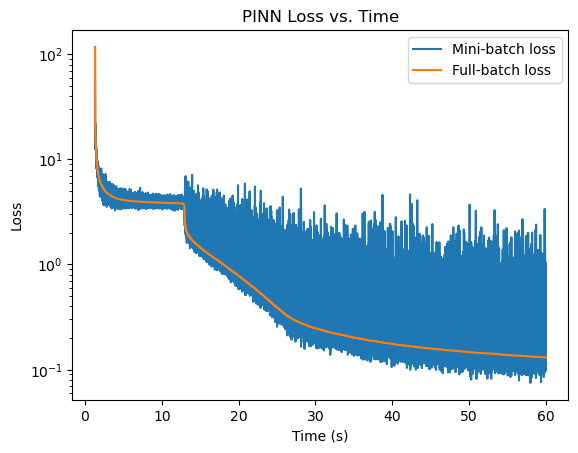

In [16]:
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 2], label='Mini-batch loss'); plt.yscale('log');
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 3], label='Full-batch loss');
plt.title('PINN Loss vs. Time'); plt.xlabel('Time (s)'); plt.ylabel('Loss'); plt.legend();

#### Visualize results

DeviceArray(4.1262937, dtype=float32)

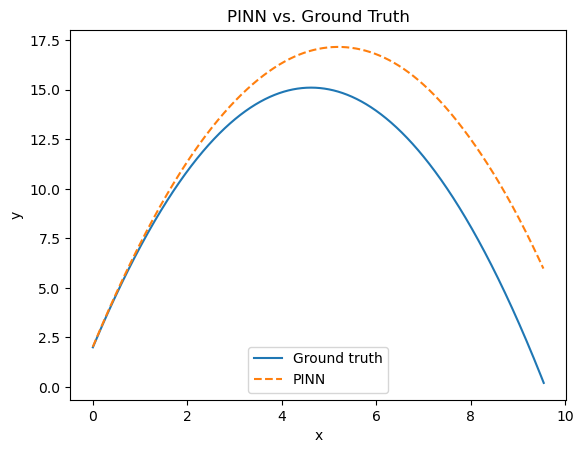

In [17]:
# plot result with best full-batch loss
hello = PINNs()
prediction = hello.apply(format_params_fn(papas[-1]), data_pde)
x, y = prediction[:,0:1], prediction[:,1:2]

plt.plot(labels_pde_x, labels_pde_y, label = "Ground truth"); plt.plot(x, y, '--', label = "PINN");
plt.legend(loc='lower center'); plt.title('PINN vs. Ground Truth'); plt.xlabel('x'); plt.ylabel('y');
jnp.mean((jnp.hstack([labels_pde_x, labels_pde_y]) - jnp.hstack([x, y]))**2)

Write PINN prediction & ground truth to file

In [18]:
#np.save('projectile_sgd_minibatch_60s', (x, y, labels_pde_x, labels_pde_y))